No GPU available, using the CPU instead.


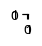

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

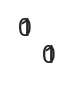

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [4]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


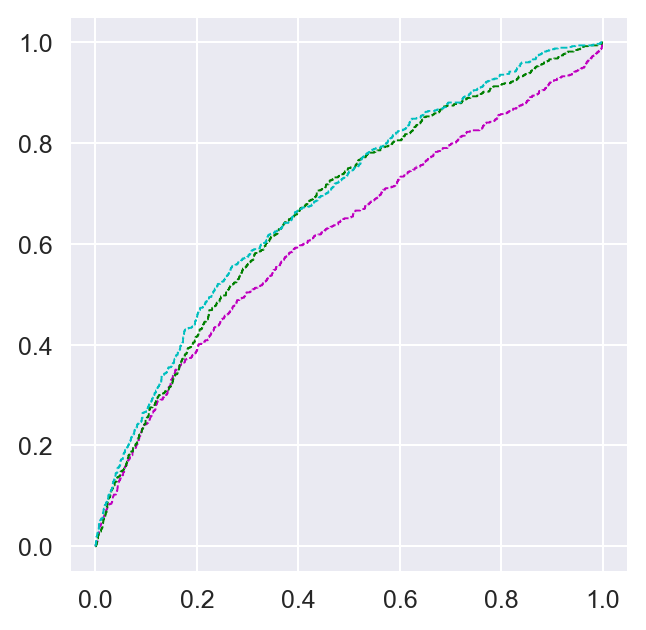

In [5]:
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [6]:
from src.baselines import plot_related_baseline_roc

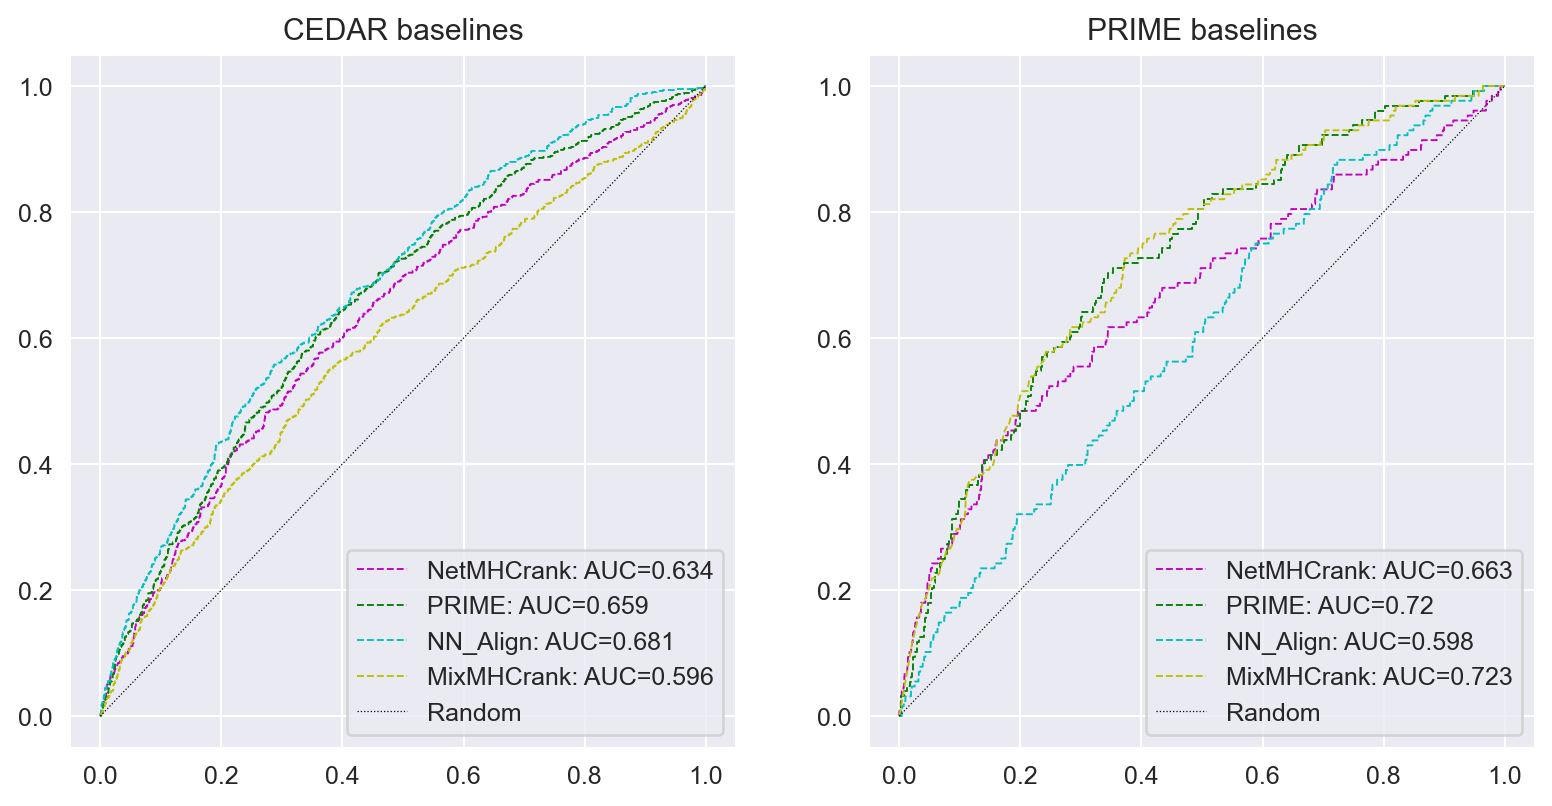

In [7]:
f,a = plt.subplots(1,2, figsize=(10.5,5))
plot_related_baseline_roc(a[0], dataset=cedar_related_baseline)
plot_related_baseline_roc(a[1], dataset=prime_related_baseline)
a[0].set_title('CEDAR baselines')
a[1].set_title('PRIME baselines')
a[0].legend()
a[1].legend()

# icore checks

In [8]:
a11_neg = cedar_related.query('HLA=="HLA-A1101" and agg_label==0')
a11_pos = cedar_related.query('HLA=="HLA-A1101" and agg_label==1')

In [11]:
a11_neg.groupby('len').count()['Peptide'], a11_pos.groupby('len').count()['Peptide']

(len
 9     87
 10    84
 11    51
 Name: Peptide, dtype: int64,
 len
 9     13
 10     9
 11     8
 Name: Peptide, dtype: int64)

In [16]:
for i in [9,10,11]:
    print(ics_kl[i]['HLA-A1101'][.25])

[0.18385369 0.37802923 0.07360033 0.07388129 0.05566523 0.06957536
 0.08311998 0.06252117 0.80499918]
[0.26761715 0.27048063 0.07935949 0.05744303 0.09500953 0.08204702
 0.07815212 0.08592608 0.06600317 0.89426077]
[0.30548366 0.31755446 0.06612274 0.10419441 0.05455265 0.08789171
 0.0857424  0.07318113 0.09507934 0.07278602 0.91949359]


In [17]:
for i in [9,10,11]:
    print(ics_kl[i]['HLA-A0201'][.25])

[0.11746793 0.66522043 0.0785592  0.16171033 0.04201341 0.12213067
 0.06663955 0.07567196 0.56553377]
[0.17517699 0.58873319 0.17047195 0.15382747 0.16596275 0.07511299
 0.11677207 0.07349111 0.09060284 0.64484803]
[0.1835251  0.60994186 0.09197235 0.20214534 0.05157637 0.16283102
 0.06639839 0.0969701  0.0757412  0.10131245 0.65326965]


In [18]:
cedar_related['same_icore'] = cedar_related['Peptide']==cedar_related['icore_mut']

In [19]:
print(len(cedar_related.query('same_icore==True')))
cedar_related.query('same_icore==True').groupby('len').count()

2179


,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,PMIDs,Peptide_mut,Peptide_wt,Pos_mut,...,wt_true,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,same_icore
len,,,,,,,,,,,,,,,,,,,,,
9,1495,1495,1495,1495,1495,1495,1495,1495,1495,1495,...,1495,1495,1495,1495,1495,1495,1495,1495,1495,1495
10,447,447,447,447,447,447,447,447,447,447,...,447,447,447,447,447,447,447,447,447,447
11,236,236,236,236,236,236,236,236,236,236,...,236,236,236,236,236,236,236,236,236,236
12,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [20]:
print(len(cedar_related.query('same_icore==False')))
cedar_related.query('same_icore==False').groupby('len').count()

854


,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,PMIDs,Peptide_mut,Peptide_wt,Pos_mut,...,wt_true,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,same_icore
len,,,,,,,,,,,,,,,,,,,,,
9,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,36,36,36,36,36
10,428,428,428,428,428,428,428,428,428,428,...,428,428,428,428,428,428,428,428,428,428
11,389,389,389,389,389,389,389,389,389,389,...,389,389,389,389,389,389,389,389,389,389
12,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [21]:
cedar_related.query('same_icore==False').groupby('len_icore_mut').count()

,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,PMIDs,Peptide_mut,Peptide_wt,Pos_mut,...,wt_true,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,same_icore
len_icore_mut,,,,,,,,,,,,,,,,,,,,,
8,125,125,125,125,125,125,125,125,125,125,...,125,125,125,125,125,125,125,125,125,125
9,651,651,651,651,651,651,651,651,651,651,...,651,651,651,651,651,651,651,651,651,651
10,78,78,78,78,78,78,78,78,78,78,...,78,78,78,78,78,78,78,78,78,78


In [29]:
cedar_related['Peptide'].apply(len).values == cedar_related['len'].values

array([ True,  True,  True, ...,  True,  True,  True])

In [24]:
cedar_related.groupby(['HLA', 'same_icore']).agg(count = ('Peptide','count'))

count
HLA       same_icore       
HLA-A0101 False           7
          True           31
HLA-A0201 False         290
          True          878
HLA-A0202 True            8
...                     ...
HLA-C1402 True            2
HLA-C1403 False          11
          True            5
HLA-C1502 False           1
          True            5

[108 rows x 1 columns]

# A11 shuffle results

In [85]:
def shuffle_remap(x):
    shuffle_remap={'all_noA11neg':'all+A11 pos',
               'all_noA11pos':'all+A11 neg'}
    if x in shuffle_remap.keys():
        return shuffle_remap[x]
    else:
        return x 

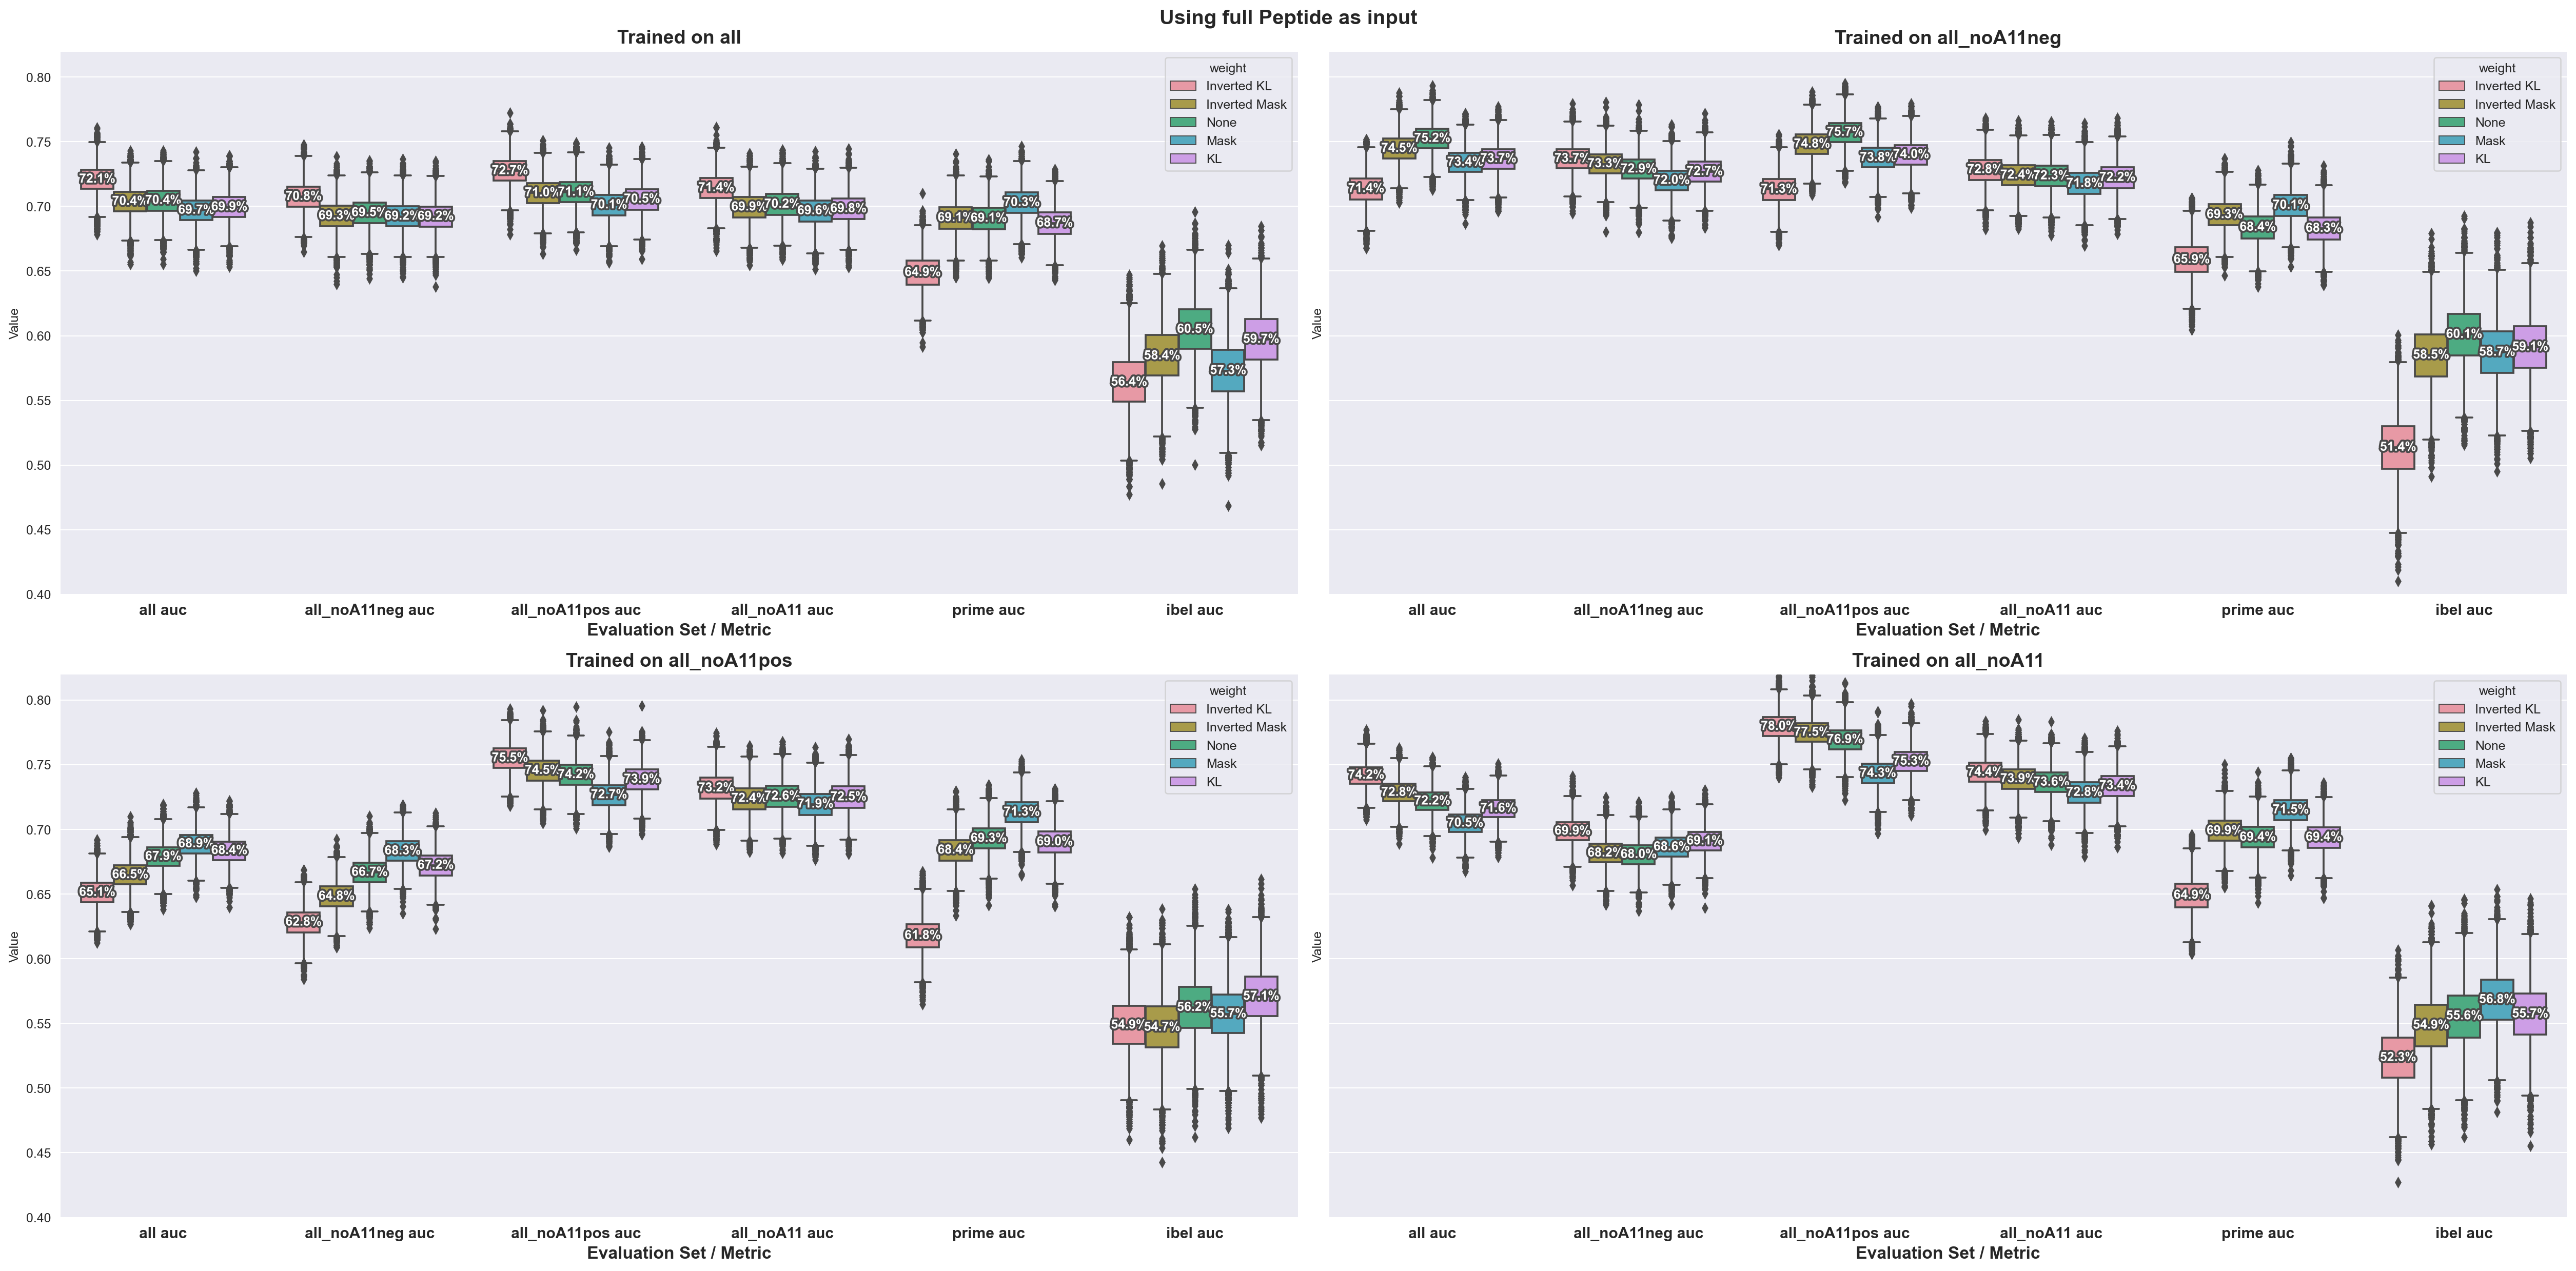

In [88]:
# All - A11 shuffle with full Pep
df_a11shuffle = pd.read_csv('../output/230109_all_a11posnegshuffle/total_df.csv').query('not weight.str.contains("Shannon")')
# df_a11shuffle['evalset'] = df_a11shuffle['evalset'].apply(shuffle_remap )
# df_a11shuffle['trainset'] = df_a11shuffle['trainset'].apply(shuffle_remap )

weight_order = ['Inverted KL',  'Inverted Mask', 'None',
                'Mask',  'KL']

f,a = plt.subplots(2, 2, figsize=(28,14),
                   sharey=True)
# f.suptitle('xd',
#           fontweight='semibold', fontsize = 14.5)
for trainset, axis in zip(df_a11shuffle.trainset.unique(), a.ravel()):
    
    tmp_df = pd.melt(df_a11shuffle.query('trainset==@trainset'),
                     id_vars = ['weight', 'evalset'], value_vars = ['auc'])
    
    tmp_df['x'] = tmp_df.apply(lambda x: ' '.join([x['evalset'], x['variable']]), axis=1)
    # tmp_df['weight'] = tmp_df['weight'].apply(replace_weight)
    sns.boxplot(data=tmp_df, x='x', hue = 'weight', y = 'value', hue_order = weight_order, ax=axis, saturation =.7)
    plt.setp(axis.collections, alpha=.75)
    axis.set_title(f'Trained on {trainset}', fontweight = 'semibold', fontsize = 15)
    axis.set_xticklabels(axis.get_xticklabels(), fontdict = dict(weight='semibold', size=12), ha = 'center')
    axis.set_xlabel('Evaluation Set / Metric', fontweight='semibold', fontsize = 13.5)
    axis.set_ylabel('Value')
    axis.set_ylim([.4, .82])
    add_median_labels(axis, fmt='.1%')
f.suptitle('All - A11 shuffle\nUsing full Peptide as input', fontweight='semibold', fontsize=16)
f.tight_layout()
f.savefig('../output/230104_boxplots_pvalues/CEDAR_all_a11_posnegshuffle.png',
          dpi=200, bbox_inches='tight')

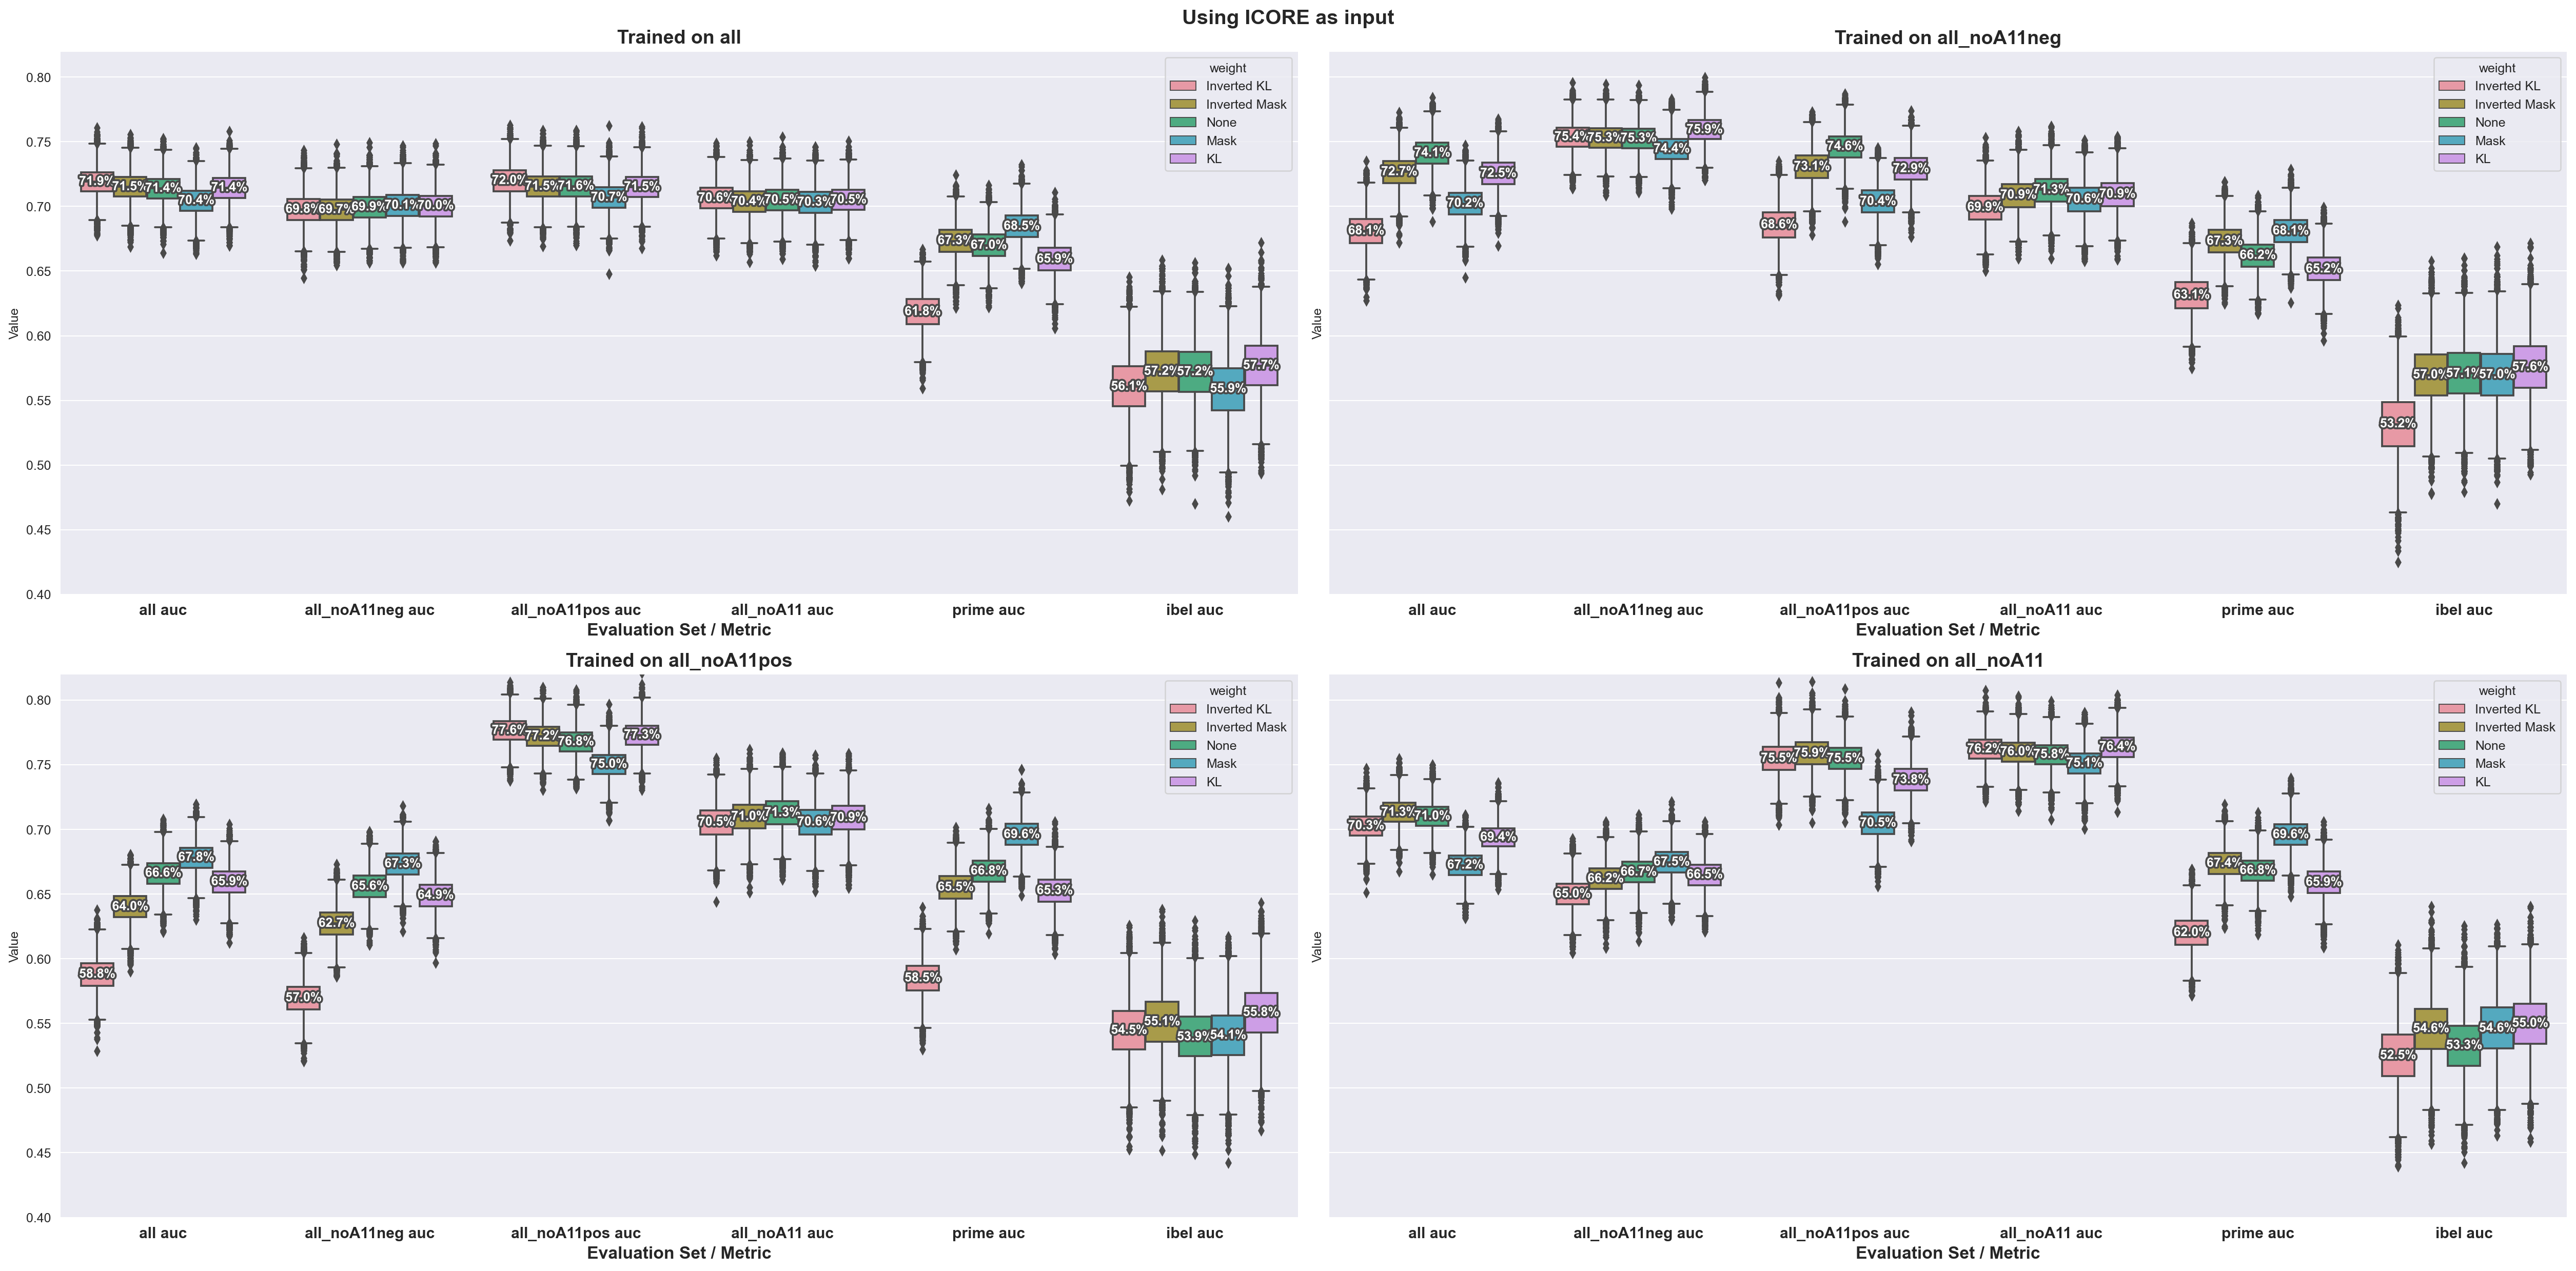

In [91]:
# All - A11 shuffle with ICORE
df_a11shuffle = pd.read_csv('../output/230109_all_a11posnegshuffle_icoremut/total_df.csv').query('not weight.str.contains("Shannon")')
weight_order = ['Inverted KL',  'Inverted Mask', 'None',
                'Mask',  'KL']
# df_a11shuffle['evalset'] = df_a11shuffle['evalset'].apply(shuffle_remap )
# df_a11shuffle['trainset'] = df_a11shuffle['trainset'].apply(shuffle_remap )

f,a = plt.subplots(2, 2, figsize=(28,14),
                   sharey=True)
# f.suptitle('xd',
#           fontweight='semibold', fontsize = 14.5)
for trainset, axis in zip(df_a11shuffle.trainset.unique(), a.ravel()):
    
    tmp_df = pd.melt(df_a11shuffle.query('trainset==@trainset'),
                     id_vars = ['weight', 'evalset'], value_vars = ['auc'])
    
    tmp_df['x'] = tmp_df.apply(lambda x: ' '.join([x['evalset'], x['variable']]), axis=1)
    # tmp_df['weight'] = tmp_df['weight'].apply(replace_weight)
    sns.boxplot(data=tmp_df, x='x', hue = 'weight', y = 'value', hue_order = weight_order, ax=axis, saturation =.7)
    plt.setp(axis.collections, alpha=.75)
    axis.set_title(f'Trained on {trainset}', fontweight = 'semibold', fontsize = 15)
    axis.set_xticklabels(axis.get_xticklabels(), fontdict = dict(weight='semibold', size=12), ha = 'center')
    axis.set_xlabel('Evaluation Set / Metric', fontweight='semibold', fontsize = 13.5)
    axis.set_ylabel('Value')
    axis.set_ylim([.4, .82])
    add_median_labels(axis, fmt='.1%')
f.suptitle('All - A11 shuffle\nUsing ICORE as input',  fontweight='semibold', fontsize=16)
f.tight_layout()
f.savefig('../output/230104_boxplots_pvalues/CEDAR_all_a11_posnegshuffle_icoremut.png',
          dpi=200, bbox_inches='tight')

In [93]:
top_hlas = ['HLA-A0201', 'HLA-A1101', 'HLA-A2402', 'HLA-B0702', 'HLA-B1501', 'HLA-B3501']

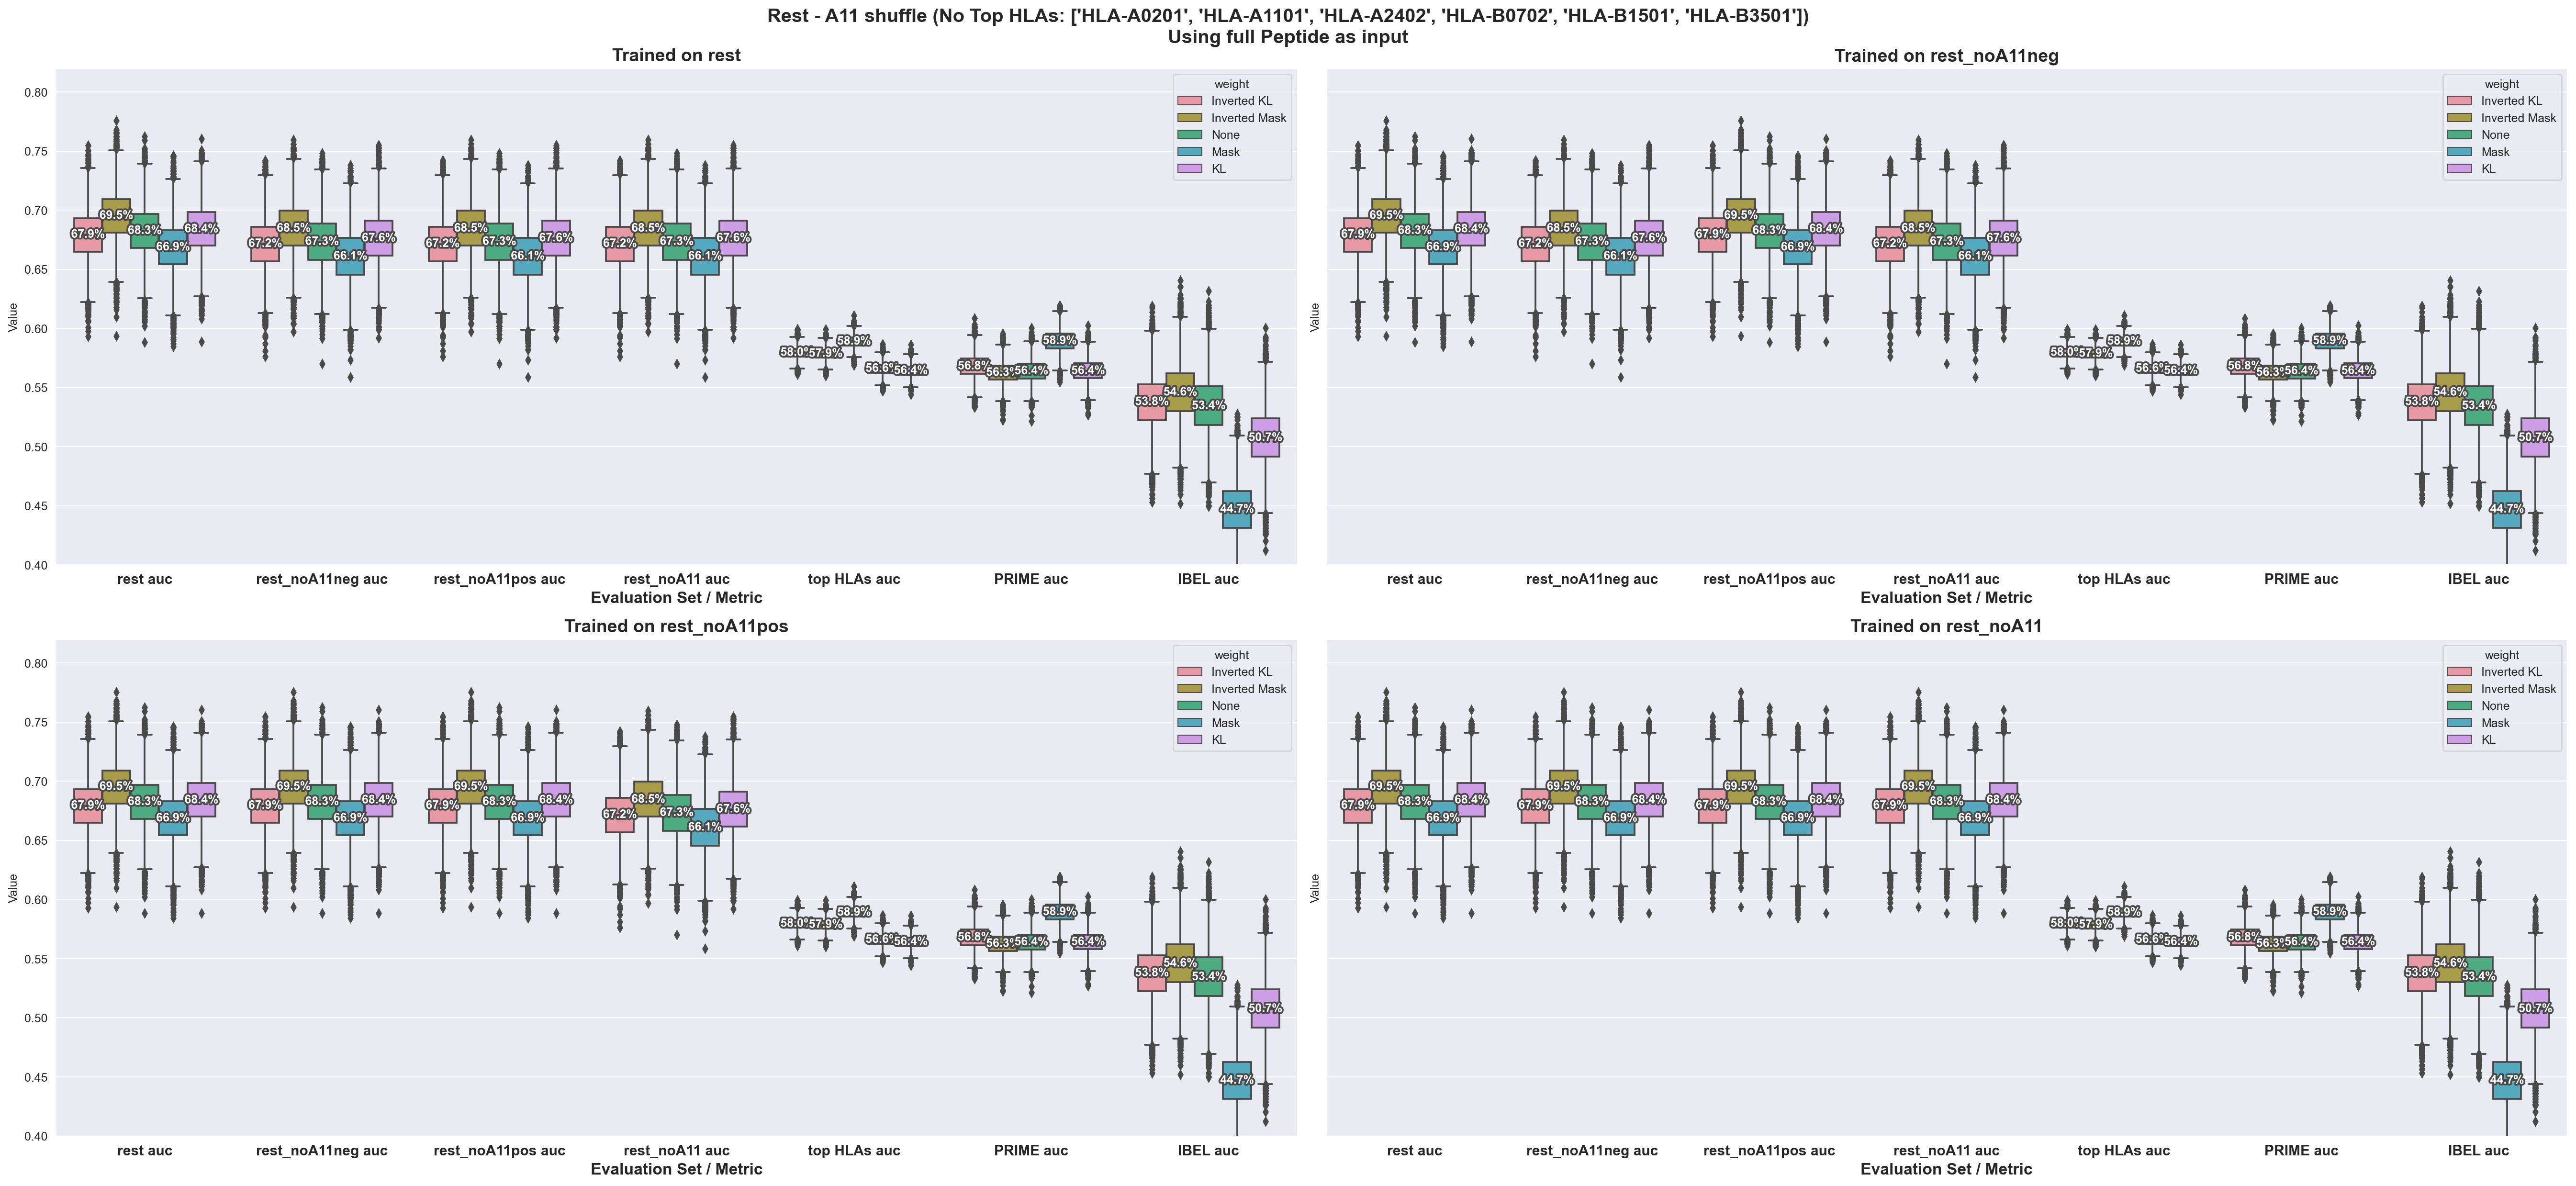

In [94]:
df_a11shuffle = pd.read_csv('../output/230111_cedar_a11rest_pnshuffle_redo/total_df.csv').query('not weight.str.contains("Shannon")')
weight_order = ['Inverted KL',  'Inverted Mask', 'None',
                'Mask',  'KL']
# df_a11shuffle['evalset'] = df_a11shuffle['evalset'].apply(shuffle_remap )
# df_a11shuffle['trainset'] = df_a11shuffle['trainset'].apply(shuffle_remap )

f,a = plt.subplots(2, 2, figsize=(30,14),
                   sharey=True)
# f.suptitle('xd',
#           fontweight='semibold', fontsize = 14.5)
for trainset, axis in zip(df_a11shuffle.trainset.unique(), a.ravel()):
    
    tmp_df = pd.melt(df_a11shuffle.query('trainset==@trainset'),
                     id_vars = ['weight', 'evalset'], value_vars = ['auc'])
    
    tmp_df['x'] = tmp_df.apply(lambda x: ' '.join([x['evalset'], x['variable']]), axis=1)
    # tmp_df['weight'] = tmp_df['weight'].apply(replace_weight)
    sns.boxplot(data=tmp_df, x='x', hue = 'weight', y = 'value', hue_order = weight_order, ax=axis, saturation =.7)
    plt.setp(axis.collections, alpha=.75)
    axis.set_title(f'Trained on {trainset}', fontweight = 'semibold', fontsize = 15)
    axis.set_xticklabels(axis.get_xticklabels(), fontdict = dict(weight='semibold', size=12), ha = 'center')
    axis.set_xlabel('Evaluation Set / Metric', fontweight='semibold', fontsize = 13.5)
    axis.set_ylabel('Value')
    axis.set_ylim([.4, .82])
    add_median_labels(axis, fmt='.1%')
f.suptitle(f'Rest - A11 shuffle (No Top HLAs: {top_hlas})\nUsing full Peptide as input',  fontweight='semibold', fontsize=16)
f.tight_layout()
f.savefig('../output/230104_boxplots_pvalues/CEDAR_rest_a11_posnegshuffle.png',
          dpi=200, bbox_inches='tight')